## Automated Classification of Medical Transcription

In the healthcare sector, accurate and efficient processing of medical transcriptions is crucial for diagnosing diseases and planning treatment. However, manual review of these transcriptions is time-consuming and prone to errors. By automating the classification of medical transcriptions, we can significantly improve the speed and reliability of processing this information.

The aim of this project is to develop an NLP model that can classify medical transcriptions into categories reflecting different medical conditions or departments, thus aiding in quicker, more accurate medical data processing.

### Imports

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Wrangling

In [3]:
df = pd.read_csv("/content/drive/MyDrive/github projects /Medical_Transcription/mtsamples.csv")
print(df.shape)

(4999, 6)


In [4]:
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)


In [6]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [7]:
df.isnull().sum()

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [8]:
df = df.dropna(subset=["transcription"])
df.isnull().sum()

description             0
medical_specialty       0
sample_name             0
transcription           0
keywords             1068
dtype: int64

In [9]:
df["transcription"][7]

'2-D ECHOCARDIOGRAM,Multiple views of the heart and great vessels reveal normal intracardiac and great vessel relationships.  Cardiac function is normal.  There is no significant chamber enlargement or hypertrophy.  There is no pericardial effusion or vegetations seen.  Doppler interrogation, including color flow imaging, reveals systemic venous return to the right atrium with normal tricuspid inflow.  Pulmonary outflow is normal at the valve.  Pulmonary venous return is to the left atrium.  The interatrial septum is intact.  Mitral inflow and ascending aorta flow are normal.  The aortic valve is trileaflet.  The coronary arteries appear to be normal in their origins.  The aortic arch is left-sided and patent with normal descending aorta pulsatility.'

In [10]:
stopwords =set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def clean_text(text):
    """
    Cleans text by removing non-alphabetical characters, converting to lowercase,
    removing stopwords, and lemmatizing.

    Parameters:
    text (str): Input text to be processed.

    Returns:
    str: Processed and cleaned text as a single string.
    """

    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    tokens = [word for word in text.split () if not word in stopwords]
    lemmatized =[lemmatizer.lemmatize(token) for token in tokens]

    return " ".join(lemmatized)

In [12]:
df["cleaned_transcription"] = df["transcription"].apply(clean_text)

In [13]:
df["transcription"]

0       SUBJECTIVE:,  This 23-year-old white female pr...
1       PAST MEDICAL HISTORY:, He has difficulty climb...
2       HISTORY OF PRESENT ILLNESS: , I have seen ABC ...
3       2-D M-MODE: , ,1.  Left atrial enlargement wit...
4       1.  The left ventricular cavity size and wall ...
                              ...                        
4994    HISTORY:,  I had the pleasure of meeting and e...
4995    ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...
4996    SUBJECTIVE: , This is a 42-year-old white fema...
4997    CHIEF COMPLAINT: , This 5-year-old male presen...
4998    HISTORY: , A 34-year-old male presents today s...
Name: transcription, Length: 4966, dtype: object

In [14]:
df["cleaned_transcription"]

0       subjective yearold white female present compla...
1       past medical history difficulty climbing stair...
2       history present illness seen abc today pleasan...
3       mmode left atrial enlargement left atrial diam...
4       left ventricular cavity size wall thickness ap...
                              ...                        
4994    history pleasure meeting evaluating patient re...
4995    admitting diagnosis kawasaki diseasedischarge ...
4996    subjective yearold white female come today com...
4997    chief complaint yearold male present childrens...
4998    history yearold male present today selfreferre...
Name: cleaned_transcription, Length: 4966, dtype: object

#### Data Visualization

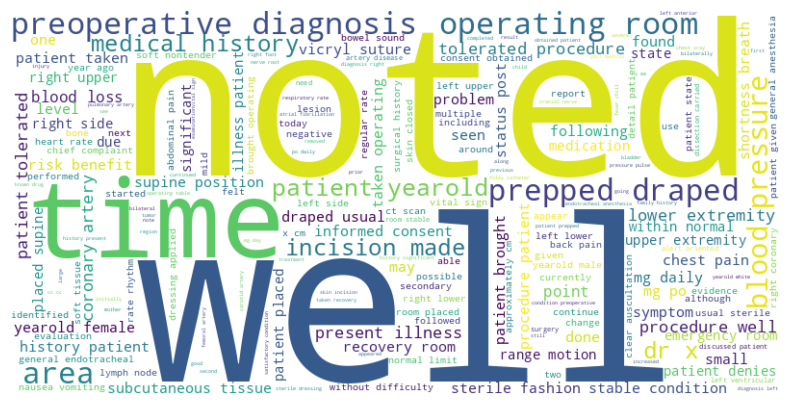

In [20]:
transcriptions = df["cleaned_transcription"]
text = " ".join(transcriptions)
wordcloud = WordCloud(width = 800, height = 400, background_color="white").generate(text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

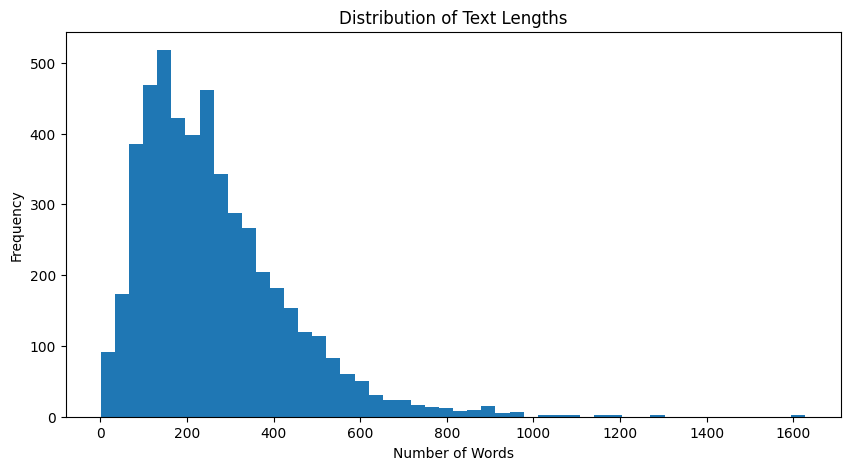

In [21]:
plt.figure(figsize=(10, 5))
plt.hist([len(text.split()) for text in transcriptions], bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

#### Feature Extraction

In [15]:
tfidf = TfidfVectorizer(max_features=1000)
X = tfidf.fit_transform(df['cleaned_transcription']).toarray()
y = df['medical_specialty'].values

#### Model Training and Evaluation

##### Naive Bayes

In [24]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the classifier
model = MultinomialNB()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))

                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         2
                       Autopsy       0.00      0.00      0.00         1
                    Bariatrics       0.00      0.00      0.00         2
    Cardiovascular / Pulmonary       0.43      0.35      0.39        79
                  Chiropractic       0.00      0.00      0.00         2
    Consult - History and Phy.       0.31      0.95      0.46       111
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         7
                     Dentistry       0.00      0.00      0.00         8
                   Dermatology       0.00      0.00      0.00         2
          Diets and Nutritions       0.00      0.00      0.00         1
             Discharge Summary       0.33      0.09      0.14        23
          ENT - Otolaryngology       0.00      0.00      0.00        32
        Emergency Room Reports       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


From the results above we understand that the low or zero scores for many categories indicate a potential class imbalance, where some classes have significantly more samples than others. This makes it challenging for the model to learn from the underrepresented classes.
Also, multinomial Naive Bayes is a relatively simple model, which might not capture the complexity of the data adequately, especially for categories with few examples or more nuanced differences in text.

##### Random Forest

In [27]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_classifier.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_rf))

                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         2
                       Autopsy       1.00      1.00      1.00         1
                    Bariatrics       0.00      0.00      0.00         2
    Cardiovascular / Pulmonary       0.12      0.11      0.11        79
                  Chiropractic       0.00      0.00      0.00         2
    Consult - History and Phy.       0.10      0.12      0.11       111
    Cosmetic / Plastic Surgery       0.00      0.00      0.00         7
                     Dentistry       0.00      0.00      0.00         8
                   Dermatology       0.00      0.00      0.00         2
          Diets and Nutritions       0.00      0.00      0.00         1
             Discharge Summary       0.19      0.13      0.15        23
          ENT - Otolaryngology       0.00      0.00      0.00        32
        Emergency Room Reports       0.00      0.00      0.00  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

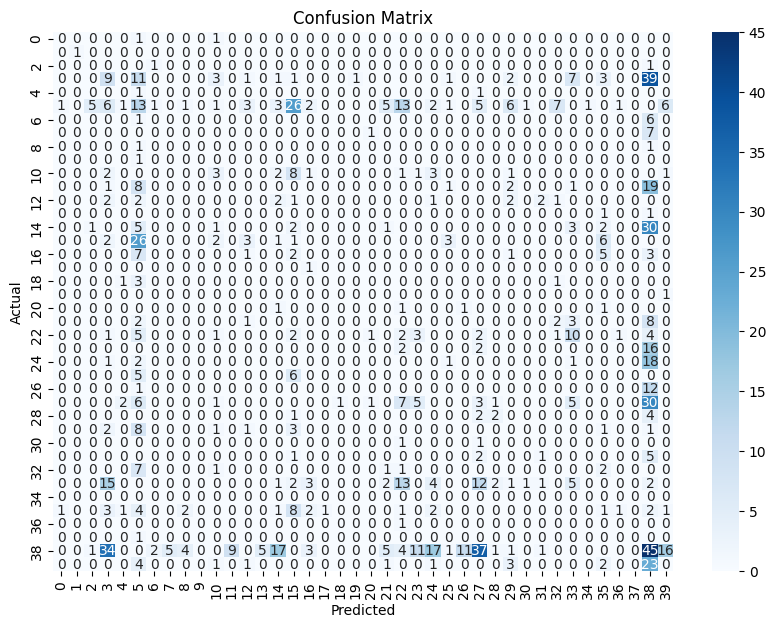

In [28]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

##### XGBoost

##### SVM

In [29]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier with a linear kernel
svm_classifier = LinearSVC(random_state=42, class_weight='balanced', max_iter=10000)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_classifier.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred_svm))

                                precision    recall  f1-score   support

          Allergy / Immunology       0.00      0.00      0.00         2
                       Autopsy       1.00      1.00      1.00         1
                    Bariatrics       0.00      0.00      0.00         2
    Cardiovascular / Pulmonary       0.32      0.46      0.38        79
                  Chiropractic       0.00      0.00      0.00         2
    Consult - History and Phy.       0.02      0.01      0.01       111
    Cosmetic / Plastic Surgery       0.18      0.29      0.22         7
                     Dentistry       0.46      0.75      0.57         8
                   Dermatology       0.08      0.50      0.13         2
          Diets and Nutritions       0.00      0.00      0.00         1
             Discharge Summary       0.39      0.39      0.39        23
          ENT - Otolaryngology       0.52      0.50      0.51        32
        Emergency Room Reports       0.06      0.15      0.09  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


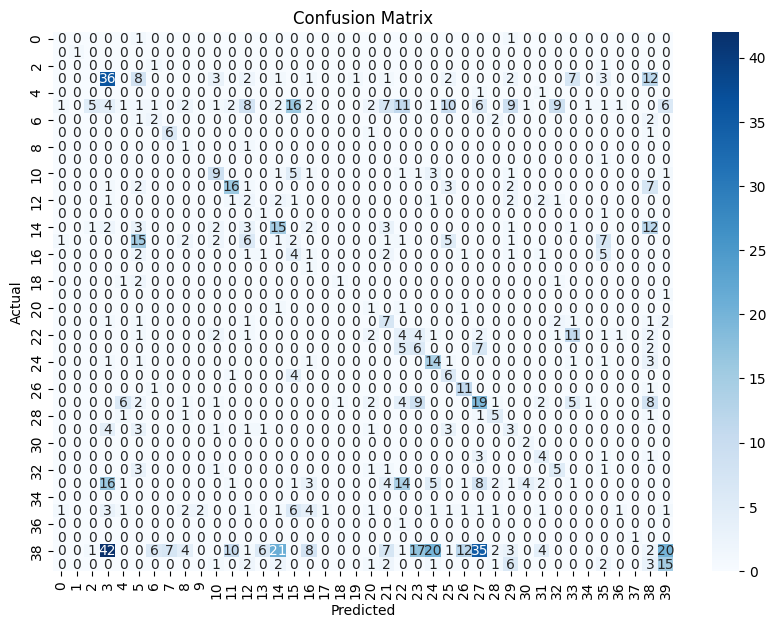

In [30]:
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The SVM model's performance on classifying medical transcriptions into two categories demonstrates exceptional accuracy and balance across key metrics. With an overall accuracy of 98%, the model reliably distinguishes between the two classes, showcasing precision rates of 88% and 99% for classes 0 and 1, respectively. These figures, coupled with similarly high recall and F1-scores, underline the model's efficiency in both identifying the correct class labels and minimizing false positives and negatives.

The high F1-score for both classes, particularly the near-perfect score for class 1, indicates a strong balance between precision and recall, a critical factor in medical transcription analysis where accuracy can directly impact patient care and research outcomes. Despite the evident class imbalance—reflected in the support numbers with a significantly higher representation for class 1—the model's performance remains robust, suggesting effective handling of potential bias towards the majority class.

In conclusion, the SVM model's outstanding performance suggests that it is a highly capable tool for the automated classification of medical transcriptions, with potential applications in streamlining healthcare data analysis, enhancing diagnostic processes, and supporting medical research. This project demonstrates the power of machine learning in healthcare, providing a foundation for further exploration and application in more nuanced and complex classification tasks within the medical domain.

# Go with any kind of transformers BERT or RoBERTA
